# Overview

In [35]:
import os, importlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# a small piece of code to find the data folder
NOTEBOOK_SCRIPT = os.getcwd()

current = NOTEBOOK_SCRIPT
while 'data' not in os.listdir(current):
    current = Path(current).parent

DATA_FOLDER = os.path.join(current, 'data')

In [36]:
import data_preparation as dpre
db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
           df_save_file, 
           overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
           )
df.head()

,order_id,start_prep_date,finish_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price
0,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99278,3750,26.07
1,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99283,3750,7.11
2,18671223,2024-05-08 00:01:21,2024-05-08 00:25:12,20.145,3934,F,35.0,99285,3750,7.11
3,18671225,2024-05-08 00:02:01,2024-05-08 00:10:29,15.800,560,F,15.0,298529,5863,31.60
4,18671227,2024-05-08 00:01:50,2024-05-08 00:49:19,6.004,4396,F,20.0,399309,8721,30.02


# Data Preparation

## Whole-dataset preparation
Before proceeding with the train-split procedure, it is necessary to apply few operations on the entire dataset: 

* compute the labels
* sanity check: no samples have a negative label
* remove few problematic samples (with prep time equal to 0)
* remove samples with `planned_prep_time` missing 

The data has been prepared (with SQL) such that for a single order neither `finish_prep_date` nor `start_prep_date` would be missing and the natural relation `finish_prep_date` > `start_prep_date` is preserved. The label for a given order is the difference of these two values and hence a missing value in one of them would mean a missing label. 

Imputing missing labels is highly discouraged as it is likely to introduce bias according to the first chapter of [Multivariate Analysis](https://www.drnishikantjha.com/papersCollection/Multivariate%20Data%20Analysis.pdf). 

Since `planned_prep_time` is intuitively a very good indicator of the actual preparation time, we will also remove the very few samples with missing `planned_prep_time`. 

In [37]:
missing_data = np.mean(df.isna(), axis=0)
missing_data 

order_id             0.000000
start_prep_date      0.000000
finish_prep_date     0.000000
profit               0.099278
delivery_distance    0.000000
status_id            0.000000
planned_prep_time    0.000004
product_id           0.000000
store_id             0.000000
price                0.100164
dtype: float64

In [38]:
import data_preparation as dpre
all_data = dpre.prepare_all_data_regression(df)
all_data

zero prep time portion:  0.00115958265972316
ratio of samples with missing `planned_prep_time`: 3.65359198328847e-06


,order_id,start_prep_date,profit,delivery_distance,status_id,planned_prep_time,product_id,store_id,price,y
0,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99278,3750,26.070,23.0
1,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99283,3750,7.110,23.0
2,18671223,2024-05-08 00:01:21,20.145,3934,F,35.0,99285,3750,7.110,23.0
3,18671225,2024-05-08 00:02:01,15.800,560,F,15.0,298529,5863,31.600,8.0
4,18671227,2024-05-08 00:01:50,6.004,4396,F,20.0,399309,8721,30.020,47.0
...,...,...,...,...,...,...,...,...,...,...
1096079,20562723,2024-09-05 15:23:44,43.608,459,F,20.0,422385,10825,54.510,14.0
1096080,20562753,2024-09-05 15:25:19,30.336,1368,F,10.0,663639,3856,13.430,10.0
1096081,20562753,2024-09-05 15:25:19,30.336,1368,F,10.0,978719,3856,47.242,10.0
1096082,20562761,2024-09-05 15:25:33,45.504,2205,F,15.0,230021,5014,14.220,6.0


## Split Data

The samples contains both order-level and item-level features. The samples belonging to the same order share most of the features and most importantly the label.

Hence data splitting should take this information into account and split the data by order_id. In other words, the train and test splits must have disjoint set of orders (order_ids)

In [39]:
# according to the assignment requirements, the data must be split into train and test with test representing 10% of the data
importlib.reload(dpre)
df_train, df_test = dpre.df_split_regression(all_data, splits=(0.9, 0.1))
# everything seems to checkout !!!
len(df_train), len(df_test), round(len(df_train) / len(df_test), 4) 

(985287, 109522, 8.9962)

## Impute Missing data:  The price and profit columns

### Price Feature Imputation
Let's start with the idea. It seems reasonable to assume that a product would relatively close values. If we're lucky we can estimate the price of a product, by the aggregation of prices of other instances of the same product.

### Profit 
Unlik the price feature, the profit is computed across the entire order. Considering every combination of store_id and product_id, the `min` statistics is the tightest estimation for the profit a store makes on a product.
why ? simply because orders can have multiple products and hence the `profit` on the entire order is at least as large as that on a single product. the `min` statistics is the truth value for any product that has been purchased as a single product at least once.

# EDA

## Labels: preparation time

In [40]:
y_train_by_order_df = pd.pivot_table(df_train, index='order_id', values='y', aggfunc='mean').iloc[:, 0]
y_train_by_order_df

order_id
18671223    23.0
18671225     8.0
18671227    47.0
18671229    11.0
18671231    33.0
            ... 
20562617    17.0
20562673    16.0
20562723    14.0
20562753    10.0
20562761     6.0
Name: y, Length: 377106, dtype: float64

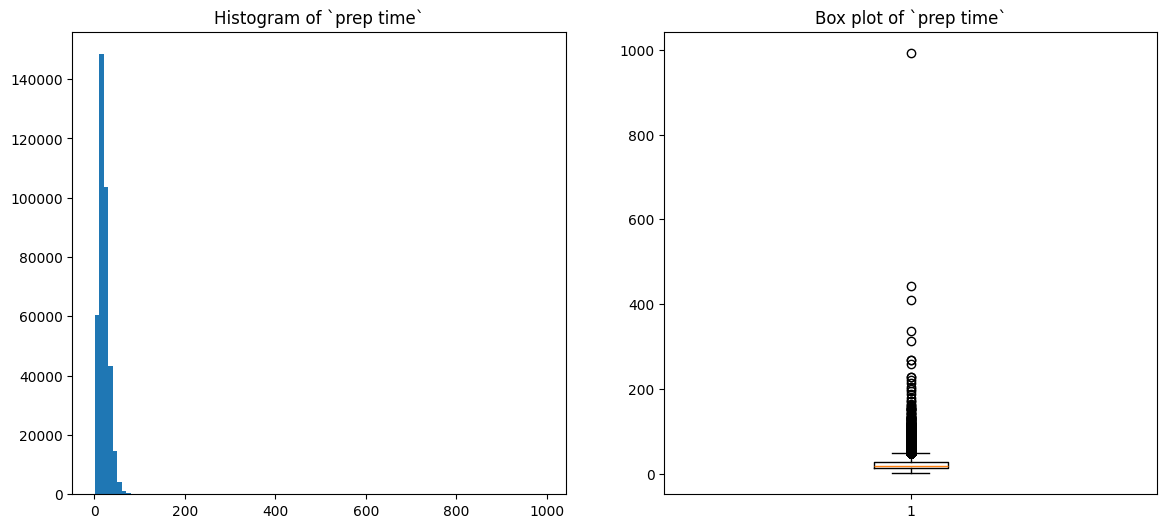

In [41]:
# let's visualize the distribution of labels: both box plot and histograms
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6)) 
fig.add_subplot(1, 2, 1) 

plt.hist(y_train_by_order_df, bins=100)
plt.title("Histogram of `prep time`")

fig.add_subplot(1, 2, 2) 
plt.boxplot(y_train_by_order_df)
plt.title("Box plot of `prep time`")
plt.show()

The histogram clearly demonstrates the skewed distribution of preparation time. Furthermore, the box plot confirms the presence of a relatively large number of outliers. 

In [42]:
import eda
y_train_ = df_train['y']
min_val, max_val = eda.compute_iqr_limiters(y_train_by_order_df)
min_val, max_val

(-8.0, 48.0)

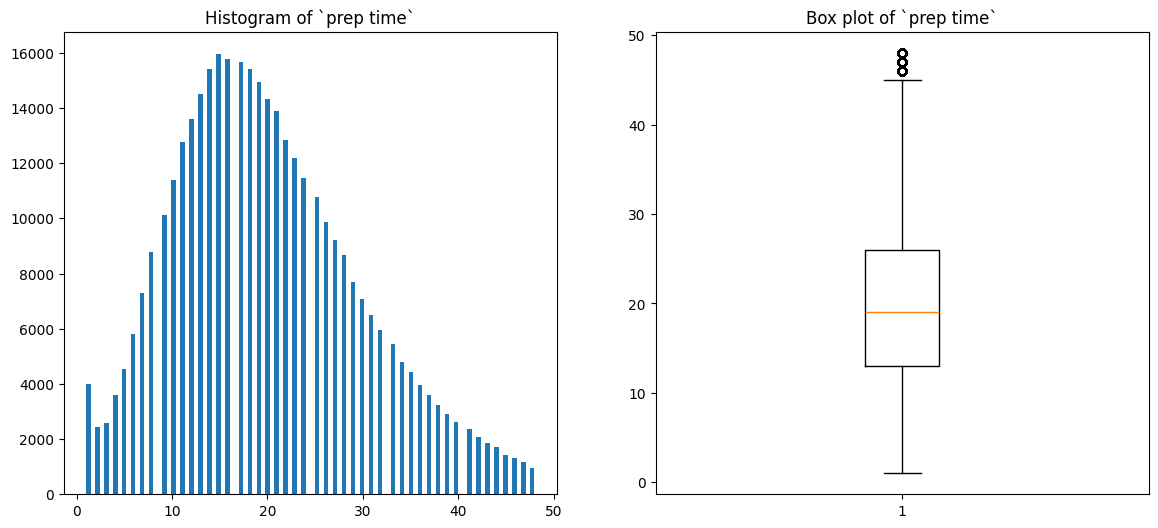

In [43]:
y_filtered = y_train_by_order_df[y_train_by_order_df.between(min_val, max_val)]
fig = plt.figure(figsize=(14, 6)) 
fig.add_subplot(1, 2, 1) 

plt.hist(y_filtered, bins=100)
plt.title("Histogram of `prep time`")

fig.add_subplot(1, 2, 2) 
plt.boxplot(y_filtered)
plt.title("Box plot of `prep time`")
plt.show()

The two visualizations above clearly demonstrate the significant of outliers on data distribution. Therefore, it seems reasonable to remove such samples. However, The only concern here is data loss: How much data would we lose ?

In [44]:
mask = y_train_by_order_df.between(min_val, max_val)
print(np.mean(mask)) # less than 2% of the data... we can live with that...

0.9785948778327579


## Discrete Features

In [45]:
eda.iqr_outliers(df_train, column='y', add_column=True)
df_train = df_train[df_train['is_outlier'] == False]
df_train.drop(columns='is_outlier', inplace=True)

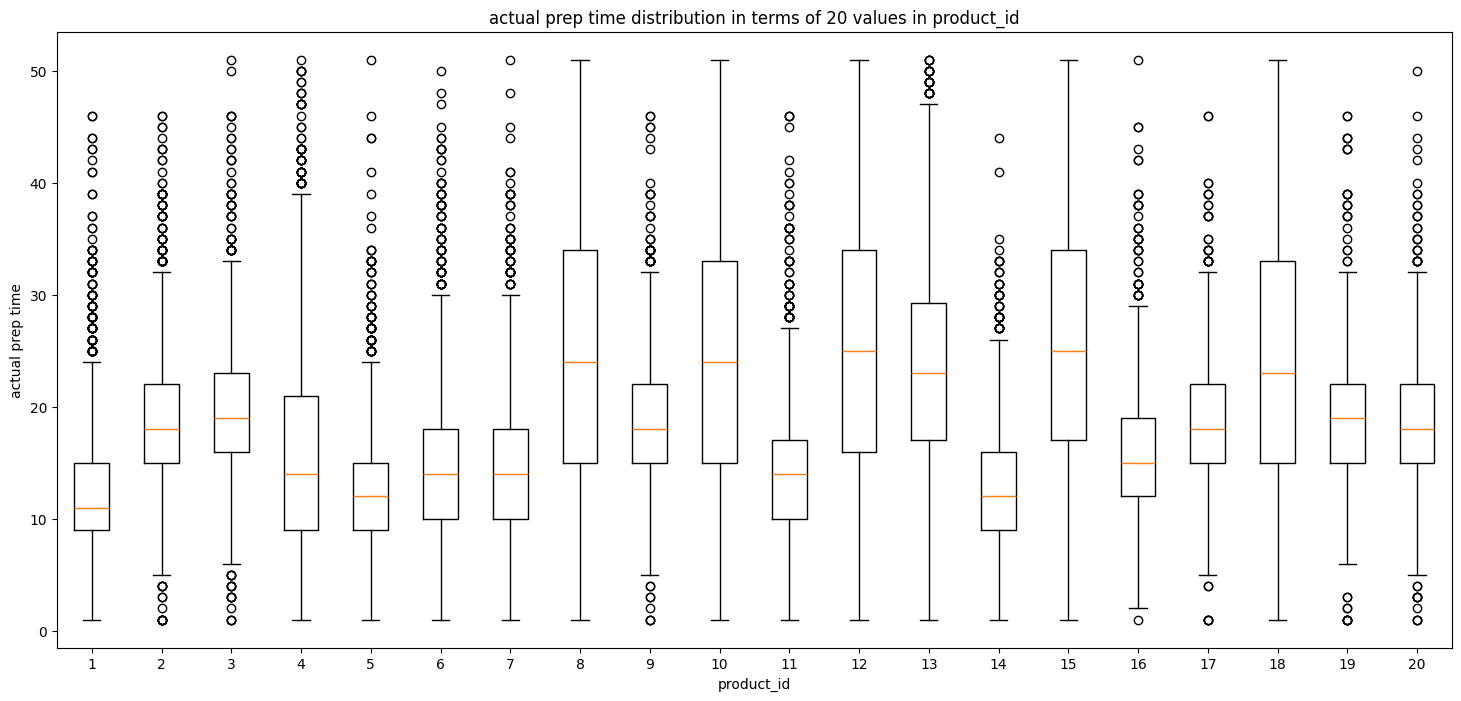

In [46]:
import visualize as vis
importlib.reload(vis)
vis.visualize_discrete_values(df_train, feat_col="product_id", label_col='y', label_name='actual prep time', n_most_freq=20)


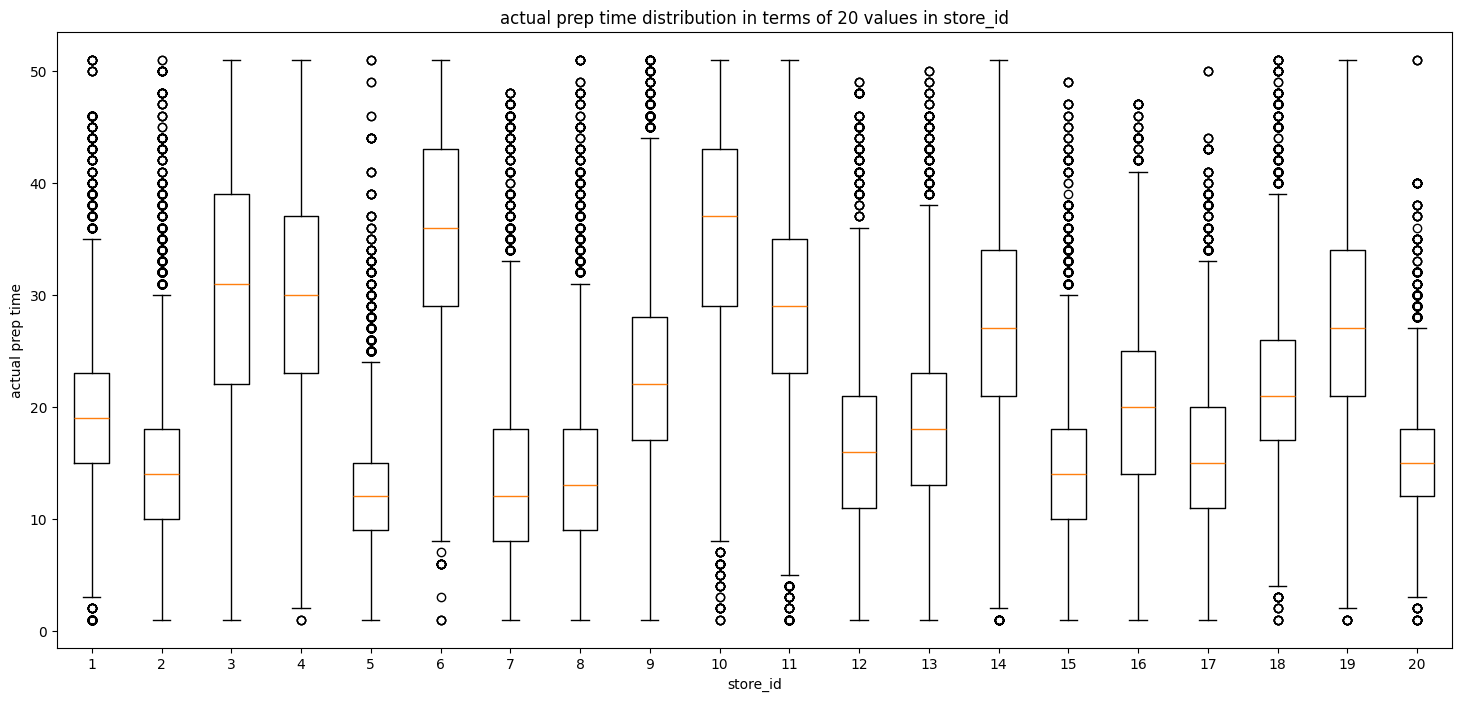

In [47]:
vis.visualize_discrete_values(df_train, feat_col="store_id", label_col='y', label_name='actual prep time', n_most_freq=20)

## Continuous features 

In [48]:
import data_processing as pro
df_train, df_test = pro.impute_prices(df_train, df_test)

# impute the missing price samples with median
df_train, df_test = pro.impute_price_with_median(df_train, df_test)

# there should be non missing values from now on 
df_train, df_test = pro.impute_profit(df_train, df_test)

In [49]:
df_train.to_csv(os.path.join(DATA_FOLDER, 'train_imputed.csv'))
df_test.to_csv(os.path.join(DATA_FOLDER, 'test_imputed.csv'))

In [50]:
numerical_feats = ['profit', 'price', 'delivery_distance', 'planned_prep_time', 'y']
# df_by_order = df_train.drop_duplicates(subset=['order_id'])
# d = df_by_order.loc[numerical_feats]
# maxtrix = pd.plotting.scatter_matrix(d, figsize=(8, 8), )

In [51]:
# let's see the effect of outliers
profit_outliers = eda.compute_iqr_limiters(df_train['profit'])
price_outliers = eda.compute_iqr_limiters(df_train['price'])
del_distance_outliers =eda.compute_iqr_limiters(df_train['delivery_distance'])

profit_outliers, price_outliers, del_distance_outliers

((-53.52250000000002, 141.44950000000003),
 (-25.652173366834155, 82.1482889447236),
 (-3757.5, 11726.5))

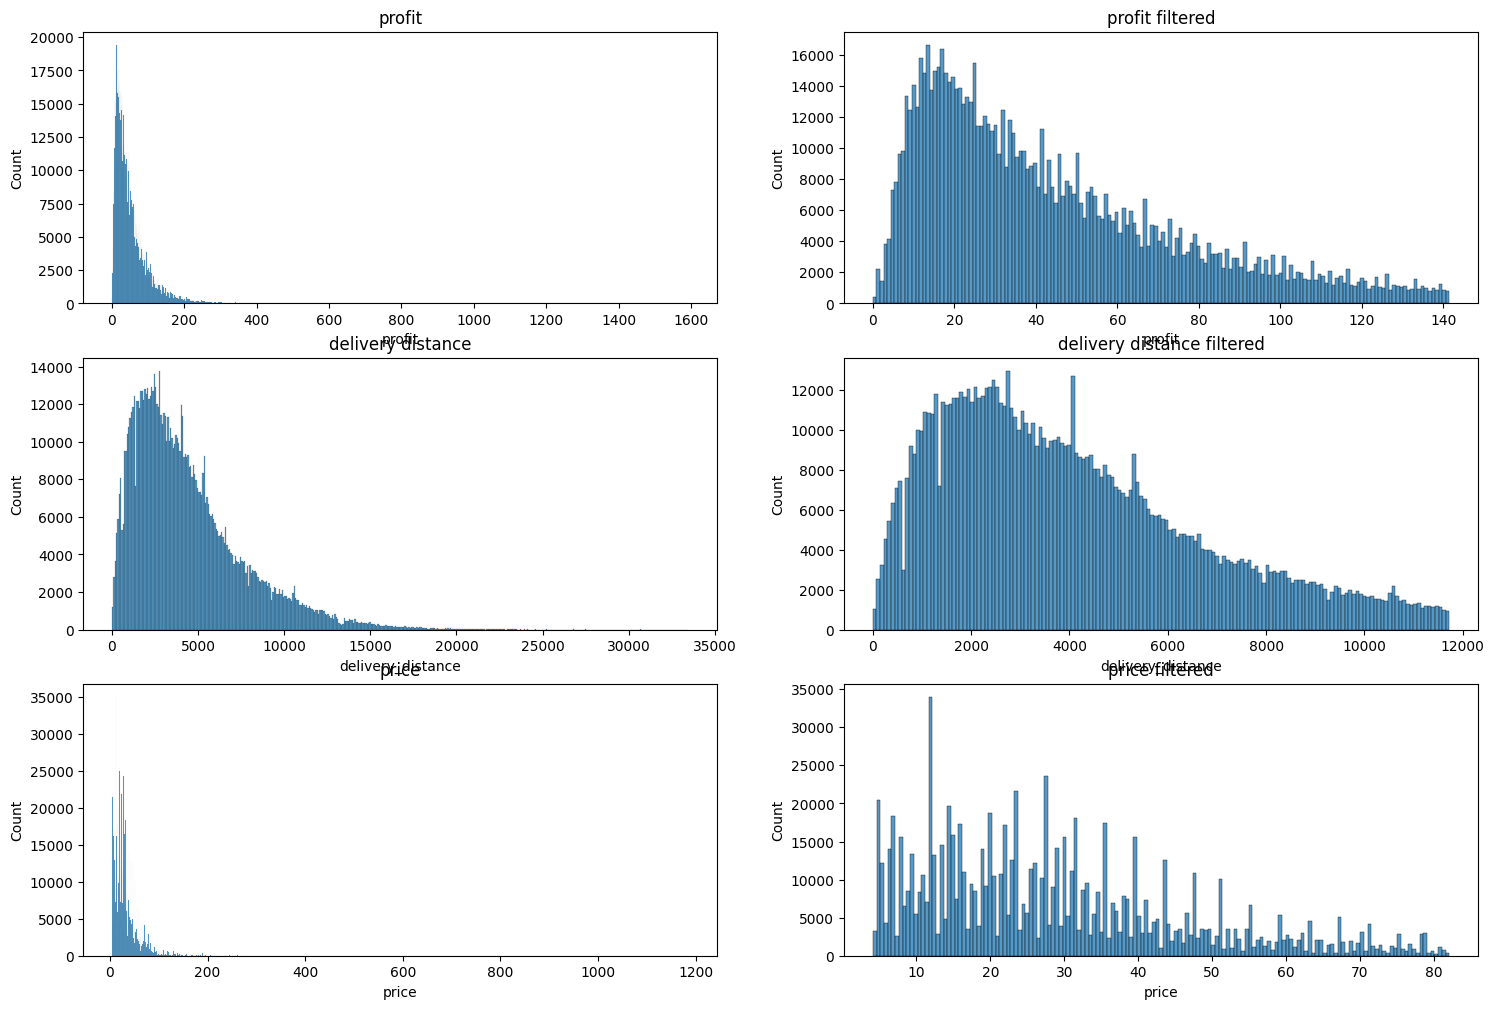

In [54]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 12))

profit_all = df_train['profit'] 
profit_filtered = df_train[df_train['profit'].between(profit_outliers[0], profit_outliers[1])]['profit']

del_distance_all = df_train['delivery_distance'] 
del_distance_filtered = df_train[df_train['delivery_distance'].between(del_distance_outliers[0], del_distance_outliers[1])]['delivery_distance']

price_all = df_train['price'] 
price_filtered = df_train[df_train['price'].between(price_outliers[0], price_outliers[1])]['price']

sns.histplot(data=profit_all,ax=axes[0, 0])
axes[0, 0].set_title('profit')
sns.histplot(data=profit_filtered,ax=axes[0, 1])
axes[0, 1].set_title('profit filtered')


sns.histplot(data=del_distance_all,ax=axes[1, 0])
axes[1, 0].set_title('delivery distance')
sns.histplot(data=del_distance_filtered,ax=axes[1, 1])
axes[1, 1].set_title('delivery distance filtered')

sns.histplot(data=price_all, ax=axes[2, 0])
axes[2, 0].set_title('price')
sns.histplot(data=price_filtered,ax=axes[2, 1])
axes[2, 1].set_title('price filtered')

plt.show()


In [59]:
# let's create a new variable that represents whether a certain sample in an outlier with respect to the distribution of the continuous features
importlib.reload(vis)
feats = ['profit', 'price', 'delivery_distance']
feats_extremes = [eda.compute_iqr_limiters(x=df_train[f]) for f in feats]
for f, fext in zip(feats, feats_extremes):
	df_train[f'{f}_is_outlier'] = (~df_train[f].between(fext[0], fext[1])).astype(int)
	

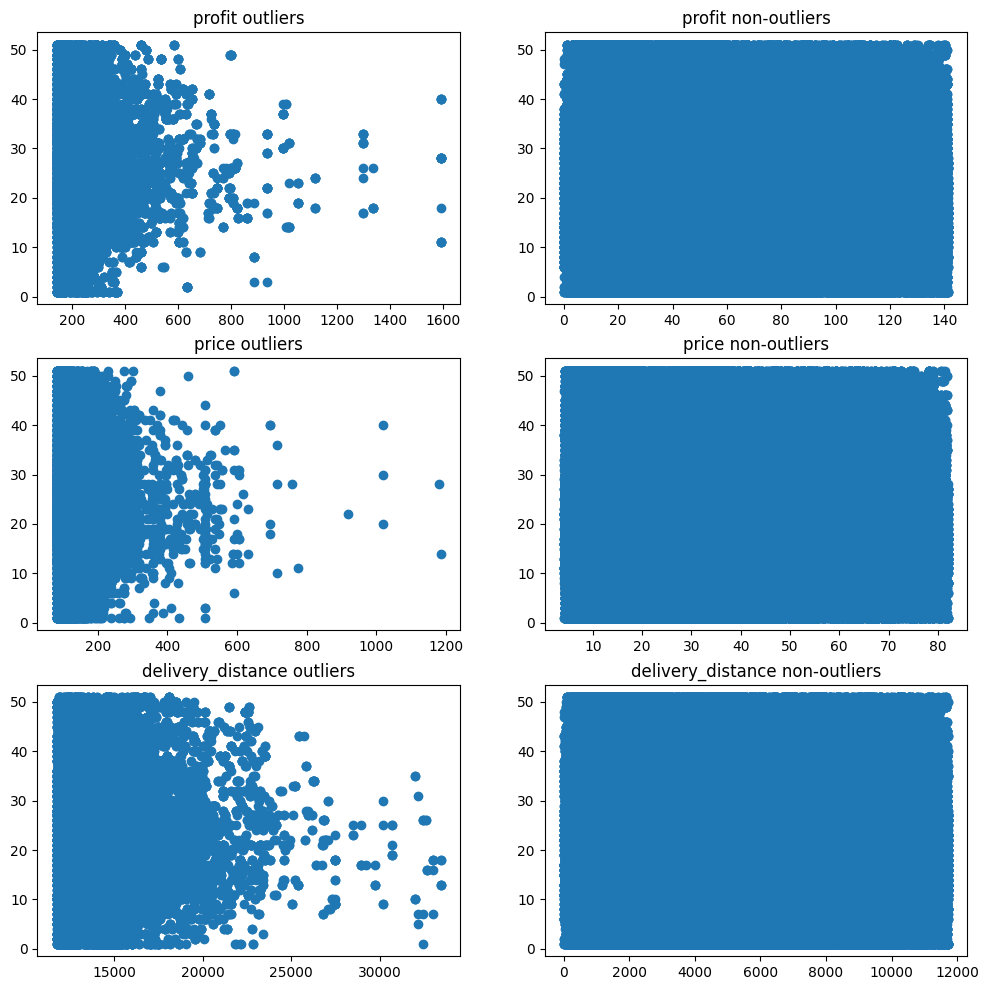

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(12, 12))
for f_index, (f, fext) in enumerate(zip(feats, feats_extremes)):
	f1, f2 = df_train[df_train[f'{f}_is_outlier'] == True][f], df_train[df_train[f'{f}_is_outlier'] == False][f] 
	y1, y2 = df_train[df_train[f'{f}_is_outlier'] == True]["y"], df_train[df_train[f'{f}_is_outlier'] == False]["y"], 

	f1 = f1.sort_values()
	f2 = f2.sort_values()

	axes[f_index, 0].scatter(f1, y1)
	axes[f_index, 1].scatter(f2, y2)

	axes[f_index, 0].set_title(f"{f} outliers")
	axes[f_index, 1].set_title(f"{f} non-outliers")

plt.show()

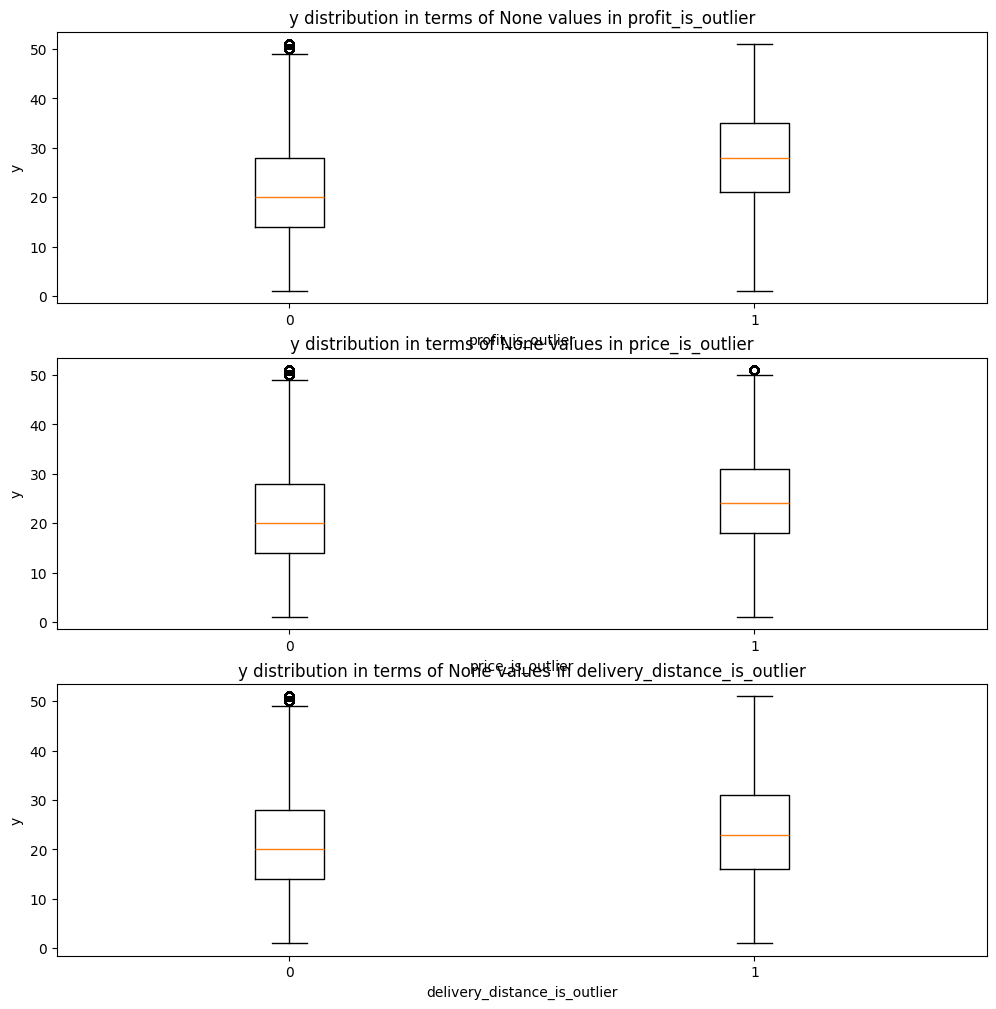

In [67]:
importlib.reload(vis)
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(12, 12))
for f_index, f in enumerate(feats):
	vis.visualize_discrete_values(df_train, 
							   feat_col=f'{f}_is_outlier', 
							   label_col='y', 
							   axes=axes[f_index], 
							   show=False, 
							   n_most_freq=None)
plt.show()

The box plots perfectly illustrate the `store_id` and `product_id`

* outliers removal
* price imputation
* profit imputation
* product_id encoding
* store_id encoding
* time features
* features scaling


In [ ]:
import data_processing as pro 
# eda.iqr_outliers(df_train, 'y', add_column=True)
# # remove them
# df_train = df_train[df_train['is_outlier'] == False]
# df_train.drop(columns=['is_outlier'], inplace=True)

# df_train, df_test = pro.impute_prices(df_train, df_test)

# # impute the missing price samples with median
# df_train, df_test = pro.impute_price_with_median(df_train, df_test)

# # there should be non missing values from now on 
# df_train, df_test = pro.impute_profit(df_train, df_test)

df_train, df_test = pro.process_data_regression(df_train, df_test)

In [ ]:
df_train.head()

In [ ]:
import seaborn as sns
# numerical_feats = ['profit', 'price', 'delivery_distance', 'planned_prep_time', 'y']

# df_train.loc[:, numerical_feats].corr()
df_train.corr()

# sns.heatmap(df_train.loc[:, numerical_feats].corr())

In [ ]:
# let's see if we can move this 

numerical_features = ['']

## Feature clasification: Encoding categorical features


Before applying feature enginnering techniques, it is important to understand the type of data we have: categorial, numerical...

The features can be classified as follows:

1. Categorical: 
	* product_id
	* store_id
	* order_id: if the product_id does not make a difference, then we will use group by the order id and reduce the number of samples...

2. Continuous:
	* planned prep time
	* price

3. time:
	* start_prep_time: extract the day of the week, the hour, the number of orders a store has received in the last "x" minutes
	* product creation time

Few observations: 

* too many products
* either discard products in general (if most of them were ordered only once or twice) or somehow laverage the frequntly ordered products
* we have few stores which means we can build some 
* the price needs to aggregated across all items in the order


# Product Ids: 
too many products, consider only the $n$ most frequent products where $n$ represent the number of products that cover $70\%$ of all orders. Out of 55k unique products, $n$ turns out to be aroun 6k: almost $10\%$. Any product id that does belong to this set was set to $-1$ as an id. This is just an intermediate step as the product ids were further encoded using the target encoder implemented by SKlearn. Although I experimented with some  custom encoding ideas of mine, The battle-test Target encoder yielded significantly better resutls. 

### Store id

We more 1.4k unique stores. One way to fully laverage the store_id is to compute the average deviation of the actual prep time from the planned one.

* region id
* more time features
* 

# Train Data Final Form

All we have done so far revolved around preparing the features: mainly imputing as much of the `price` and `profit` features and trying to embed as much information in the encoding of the `store_id` and `product_id` features.


In [ ]:
import data_processing as pro
df_train, df_test = pro.process_data_regression(df_train, df_test)
y_train, y_test = df_train.pop('y'), df_test.pop('y')

In [ ]:
df_train.isna().sum(), df_test.isna().sum()

In [17]:
df_train.to_csv(os.path.join(DATA_FOLDER, 'train.csv'), index=False)
y_train.to_csv(os.path.join(DATA_FOLDER, 'y_train.csv'), index=False)

df_test.to_csv(os.path.join(DATA_FOLDER, 'test.csv'), index=False)
y_test.to_csv(os.path.join(DATA_FOLDER, 'y_test.csv'), index=False)

In [ ]:
import data_preparation as dpre
db_file = os.path.join(DATA_FOLDER, 'F24.ML.Assignment.One.data.db')
df_save_file = os.path.join(DATA_FOLDER, 'data.csv')
df = dpre.data_to_df(db_file, 
		df_save_file, 
		overwrite=False # no need to execute the same lengthy query if the .csv file already exists...
		)
all_data = dpre.prepare_all_data_classification(df)

# df_train, df_test = process_data_regression(df_train, df_test)
print(all_data.head())

# split the data
df_train, df_test = dpre.df_split_classification(all_data, splits=(0.9, 0.1))

# everything seems to checkout !!!
print(len(df_train), len(df_test), round(len(df_train) / len(df_test), 4))

print(df_train['y_cls'].value_counts())
print(df_test['y_cls'].value_counts())

In [53]:
df_train = df_train.drop(columns='y').rename(columns={"y_cls": "y"})
df_test = df_test.drop(columns='y').rename(columns={"y_cls": "y"})

In [ ]:
df_train.head()

# Modeling

In [24]:
df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
y_train = pd.read_csv(os.path.join(DATA_FOLDER, 'y_train.csv')).squeeze()

df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
y_test = pd.read_csv(os.path.join(DATA_FOLDER, 'y_test.csv')).squeeze()

In [ ]:
df_train.isna().sum()
df_test.isna().sum()

In [ ]:
import models
importlib.reload(models)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr, lr1, lr2 = LinearRegression(), Lasso(alpha=1), Ridge(alpha=1), 
models_res = {}
for m in [lr, lr1, lr2]:
	m_name = models._extract_model_name_from_cls(m)
	models_res[m_name] = models.pipeline(df_train, y_train, df_test, y_test, m)
	print(m_name, models_res[m_name][1:])

In [27]:
from sklearn.tree import DecisionTreeRegressor
DecReg = DecisionTreeRegressor(max_depth=4, random_state=0)
models_res[models._extract_model_name_from_cls(DecReg)] = models.pipeline(df_train, y_train, df_test, y_test, DecReg)

In [ ]:
models_res[models._extract_model_name_from_cls(DecisionTreeRegressor())]

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
models_res[models._extract_model_name_from_cls(rf)] = models.pipeline(df_train, y_train, df_test, y_test, rf)

In [ ]:
models_res[models._extract_model_name_from_cls(RandomForestRegressor())]